<ipython-input-5-c5c662c62100>:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return (mse(original, denoised), psnr(original, denoised), ssim(original, denoised, data_range=denoised.max() - denoised.min()))



--- Image Denoising Metrics ---
Median Filter    =>  PSNR: 25.71, SSIM: 0.4930, MSE: 0.002687
Wavelet Denoising => PSNR: 26.84, SSIM: 0.6391, MSE: 0.002069


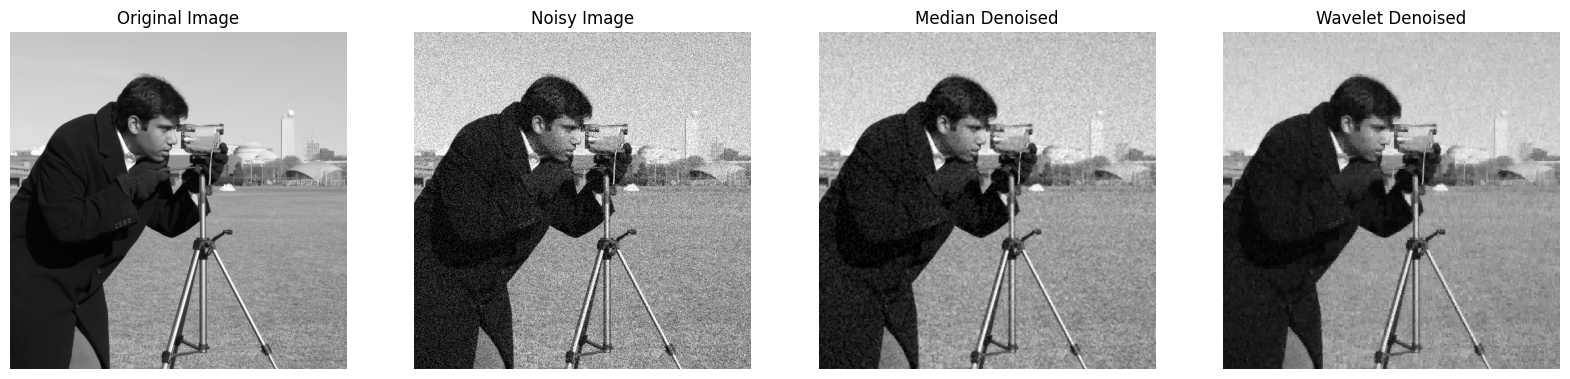

Saving SampleVideo_1280x720_1mb.mp4 to SampleVideo_1280x720_1mb.mp4

--- Extracting frames ---
Total frames extracted: 132

--- Processing frames ---


100%|██████████| 132/132 [00:07<00:00, 18.79it/s]


Video created: adaptive_thresh_video.mp4
Video created: gaussian_blur_video.mp4
Video created: canny_edges_video.mp4
Video created: bitwise_not_video.mp4

--- Building a collage ---


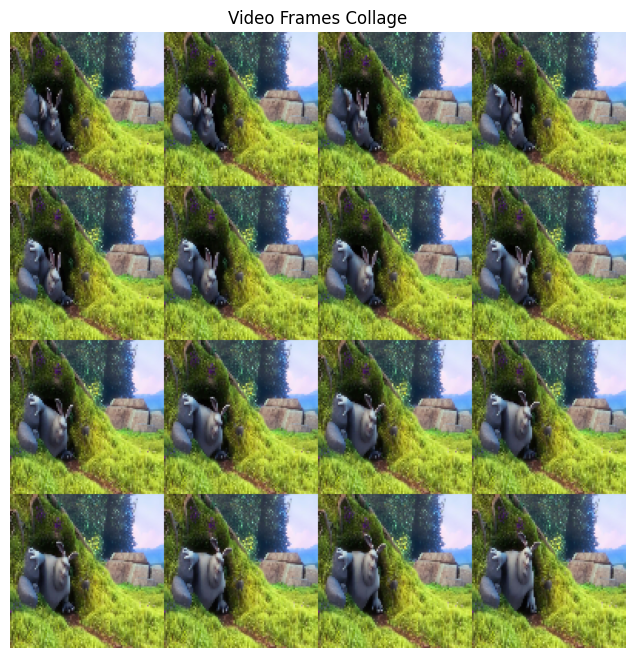

In [ ]:


# ===============================
# 📦 Install necessary libraries
# ===============================
!pip install scikit-image opencv-python-headless PyWavelets tqdm

# ===============================
# 📚 Import all libraries
# ===============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from skimage import data, img_as_float
from skimage.restoration import denoise_wavelet
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim, mean_squared_error as mse


# 1️ Image Denoising

# Load a sample grayscale image and add noise
image = data.camera()
image_gray = img_as_float(image)
noisy_image = random_noise(image_gray, mode='gaussian', var=0.01)

# Median Filter Denoising
median_denoised = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3)
median_denoised = median_denoised.astype(np.float32) / 255.0

# Wavelet Denoising
wavelet_denoised = denoise_wavelet(noisy_image, channel_axis=None, rescale_sigma=True)

# Note: Noise2Void is skipped because it requires TensorFlow model training, complex setup in Colab.

# Metric calculation
def compute_metrics(original, denoised):
    return (mse(original, denoised), psnr(original, denoised), ssim(original, denoised, data_range=denoised.max() - denoised.min()))

# Compute Metrics
mse_median, psnr_median, ssim_median = compute_metrics(image_gray, median_denoised)
mse_wavelet, psnr_wavelet, ssim_wavelet = compute_metrics(image_gray, wavelet_denoised)

# Print Metrics
print("\n--- Image Denoising Metrics ---")
print(f"Median Filter    =>  PSNR: {psnr_median:.2f}, SSIM: {ssim_median:.4f}, MSE: {mse_median:.6f}")
print(f"Wavelet Denoising => PSNR: {psnr_wavelet:.2f}, SSIM: {ssim_wavelet:.4f}, MSE: {mse_wavelet:.6f}")

# Show the Images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(image_gray, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(noisy_image, cmap='gray')
axs[1].set_title('Noisy Image')
axs[1].axis('off')

axs[2].imshow(median_denoised, cmap='gray')
axs[2].set_title('Median Denoised')
axs[2].axis('off')

axs[3].imshow(wavelet_denoised, cmap='gray')
axs[3].set_title('Wavelet Denoised')
axs[3].axis('off')

plt.show()

# 2️ Extract Images from Video


# Upload a small video manually in Colab (files.upload)
from google.colab import files
uploaded = files.upload()

# Assume uploaded video is named "video.mp4"
video_path = next(iter(uploaded))
os.makedirs('frames', exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_num = 0

print("\n--- Extracting frames ---")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = f'frames/frame_{frame_num:04d}.jpg'
    cv2.imwrite(frame_path, frame)
    frame_num += 1

cap.release()
print(f"Total frames extracted: {frame_num}")


# 3️ Process Images of Video


# Create folders for each processing type
processing_types = ['adaptive_thresh', 'gaussian_blur', 'canny_edges', 'bitwise_not']
for proc in processing_types:
    os.makedirs(proc, exist_ok=True)

# Processing functions
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    gaussian_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny_edges = cv2.Canny(gray, 100, 200)
    bitwise_not = cv2.bitwise_not(gray)
    return adaptive_thresh, gaussian_blur, canny_edges, bitwise_not

# Apply processing frame-by-frame
frame_files = sorted(os.listdir('frames'))
print("\n--- Processing frames ---")
for file in tqdm(frame_files):
    frame = cv2.imread(f'frames/{file}')
    adaptive, blur, edges, not_img = process_frame(frame)

    cv2.imwrite(f'adaptive_thresh/{file}', adaptive)
    cv2.imwrite(f'gaussian_blur/{file}', blur)
    cv2.imwrite(f'canny_edges/{file}', edges)
    cv2.imwrite(f'bitwise_not/{file}', not_img)


# 4️ Recreate Videos from Processed Frames


frame_height, frame_width = frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Create a video for each processed type
for proc in processing_types:
    out = cv2.VideoWriter(f'{proc}_video.mp4', fourcc, 20.0, (frame_width, frame_height), isColor=False)
    frames = sorted(os.listdir(proc))
    for file in frames:
        img = cv2.imread(f'{proc}/{file}', cv2.IMREAD_GRAYSCALE)
        out.write(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))  # Convert back to 3 channels
    out.release()
    print(f"Video created: {proc}_video.mp4")


# 5 Build a Collage from Frames


print("\n--- Building a collage ---")
collage_frames = frame_files[:16]  # Pick first 16 frames
collage_images = [cv2.resize(cv2.imread(f'frames/{file}'), (100, 100)) for file in collage_frames]

# Build 4x4 grid
rows = []
for i in range(0, 16, 4):
    row = np.hstack(collage_images[i:i+4])
    rows.append(row)
collage = np.vstack(rows)

# Save and display the collage
cv2.imwrite('collage.jpg', collage)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Video Frames Collage')
plt.show()
